In [196]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, roc_auc_score


In [197]:
df = pd.read_csv("dataset/telecom_customer_churn.csv")
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [198]:
print(f"Shape of df: {df.shape}")
print(df.columns)  

Shape of df: (7043, 38)
Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')


In [199]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

In [200]:
df['Offer'] = df['Offer'].fillna('None')
df['Avg Monthly Long Distance Charges'] = df['Avg Monthly Long Distance Charges'].fillna(0)
df['Multiple Lines'] = df['Multiple Lines'].fillna('No')

internet_cols_yesno = [
    'Online Security', 'Online Backup', 'Device Protection Plan',
    'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
    'Streaming Music', 'Unlimited Data'
]

df['Internet Type'] = df['Internet Type'].fillna('None')
df['Avg Monthly GB Download'] = df['Avg Monthly GB Download'].fillna(0)

for col in internet_cols_yesno:
    df[col] = df[col].fillna('No')

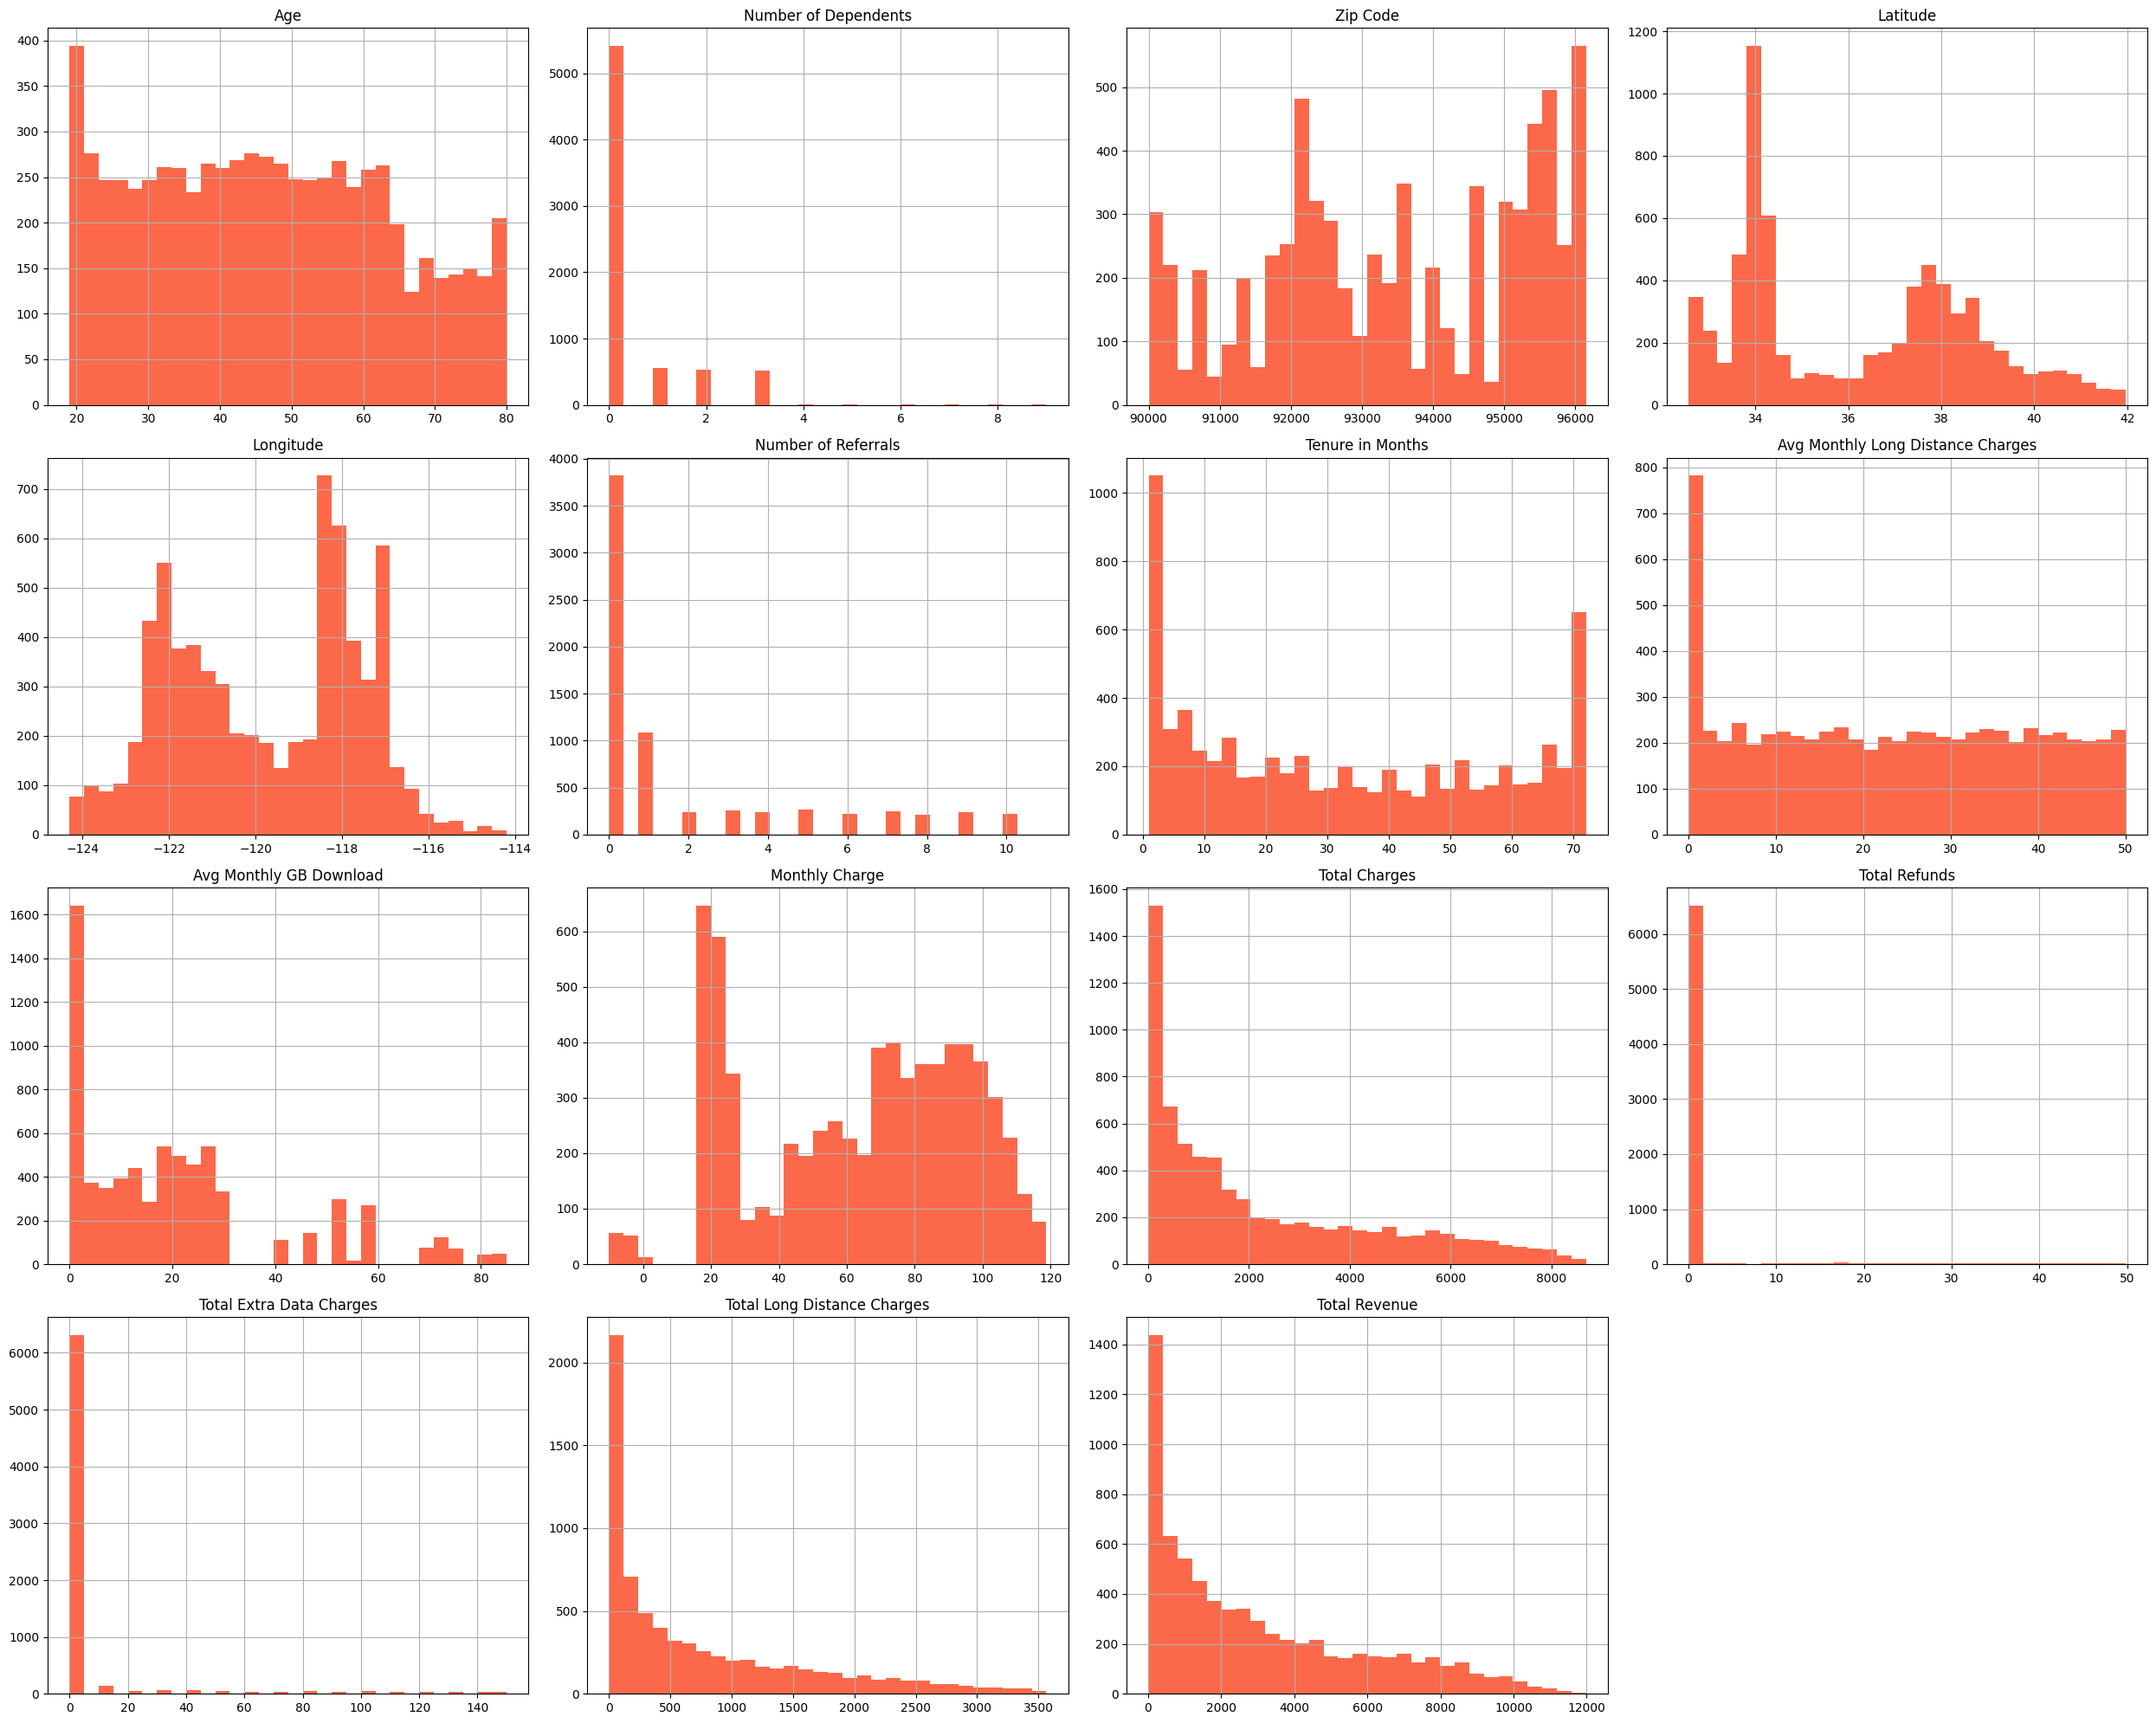

In [201]:
df.hist(
    bins=30,
    figsize=(25, 20), 
    color=sns.color_palette("Reds", 1)
)
plt.tight_layout()
plt.show()


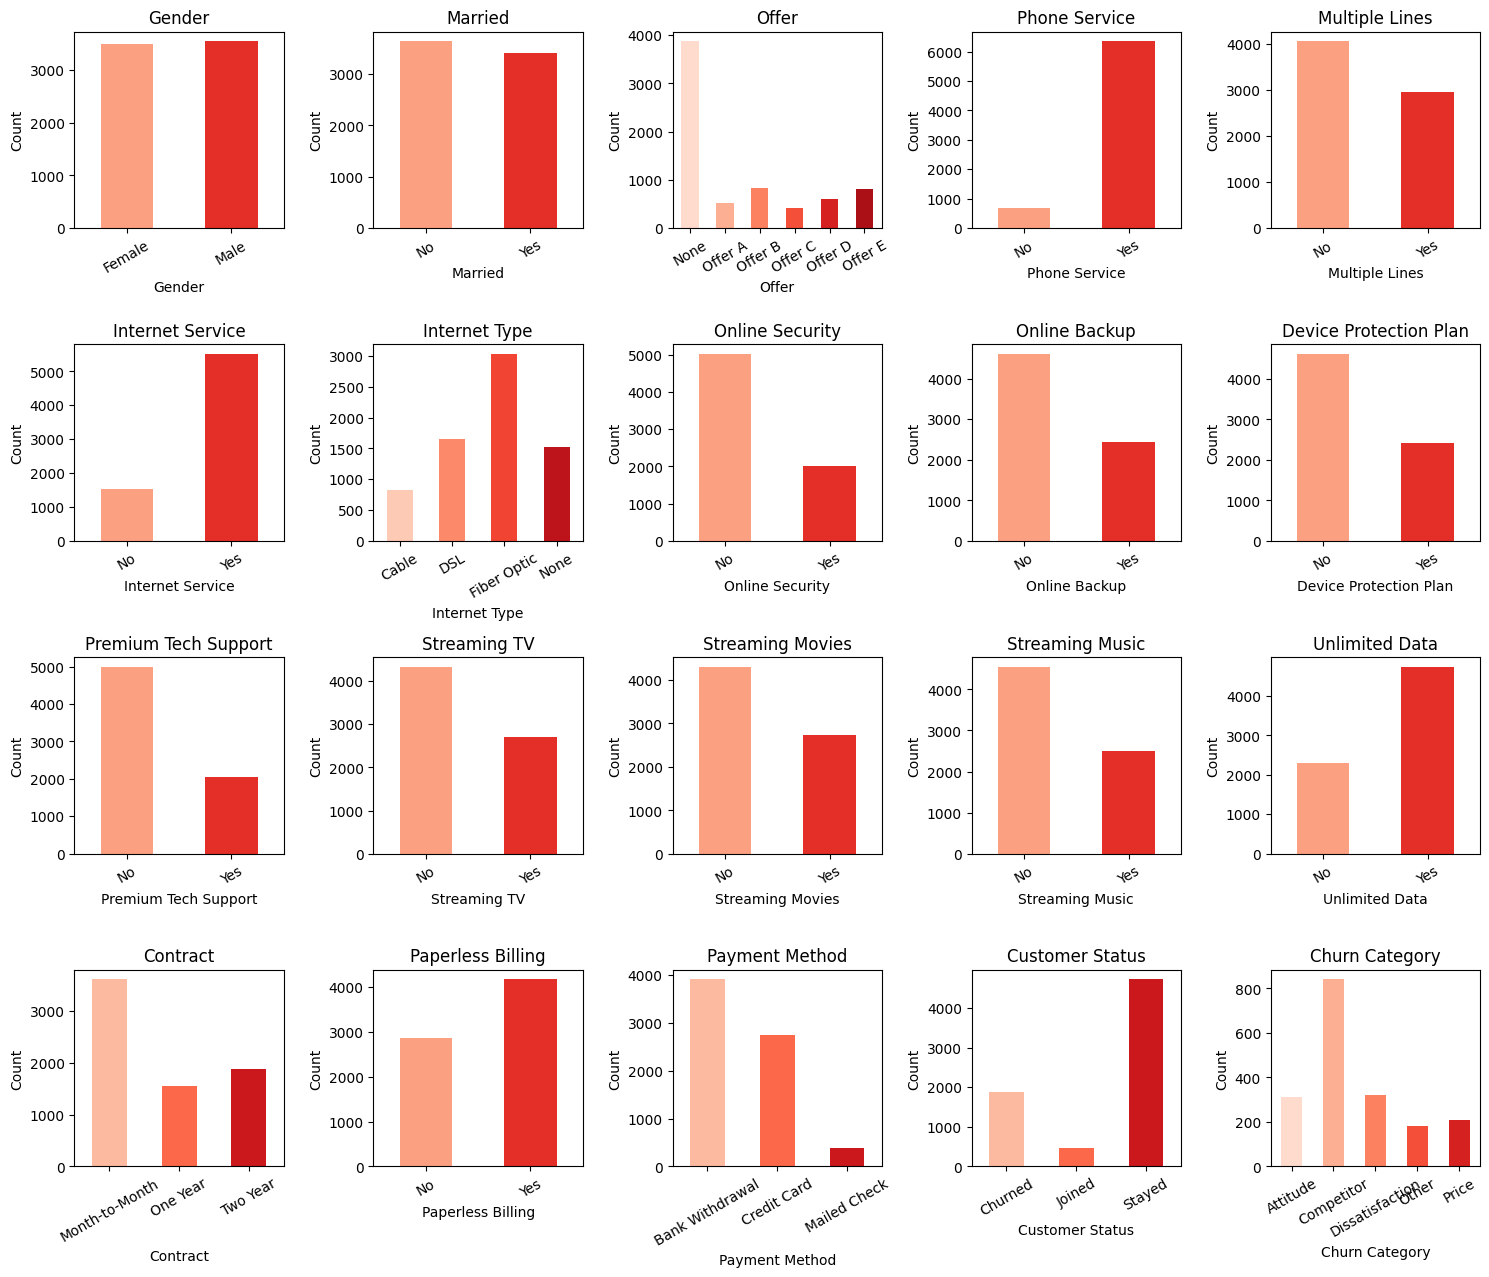

In [202]:
cat_cols = df.drop(columns = ["Customer ID", "City", "Churn Reason"]).select_dtypes(include='object').columns

ncols = 4
nrows = math.ceil(len(cat_cols) / ncols)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    df[col].value_counts().sort_index().plot(
        kind='bar',
        ax=axes[i],
        color=sns.color_palette("Reds", len(df[col].unique()))
    )

    axes[i].set_title(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=30)

# remove unused plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


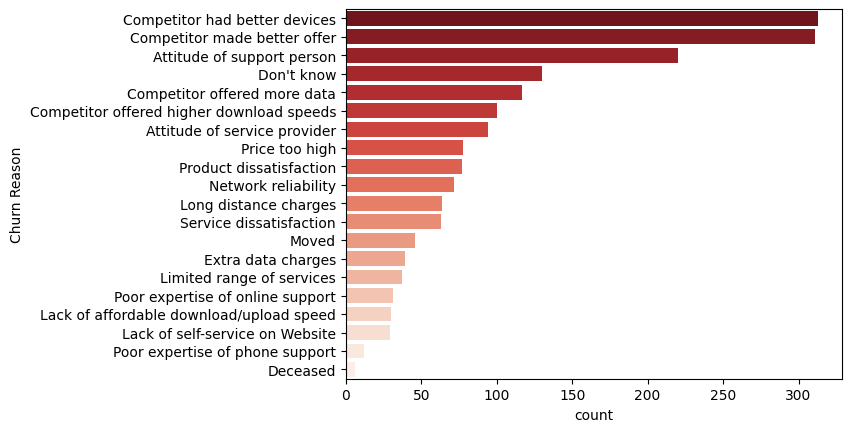

In [203]:
sns.countplot(
    data=df,
    y="Churn Reason",
    order=df["Churn Reason"].value_counts().index,
    palette="Reds_r"
)
plt.show()


Customer Status
Stayed     0.716345
Churned    0.283655
Name: proportion, dtype: float64


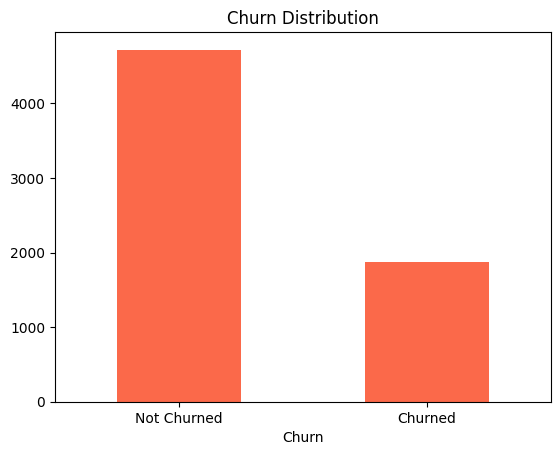

In [204]:
df = df[df["Customer Status"] != "Joined"].copy()

print(df["Customer Status"].value_counts(normalize=True))

df["Churn"] = df["Customer Status"].apply(lambda x: 1 if x == 'Churned' else 0)
df["Churn"].value_counts().plot(kind='bar', color=sns.color_palette("Reds", 1))
plt.title('Churn Distribution')
plt.xticks(rotation=0)
plt.gca().set_xticklabels(['Not Churned', 'Churned'])
plt.show()



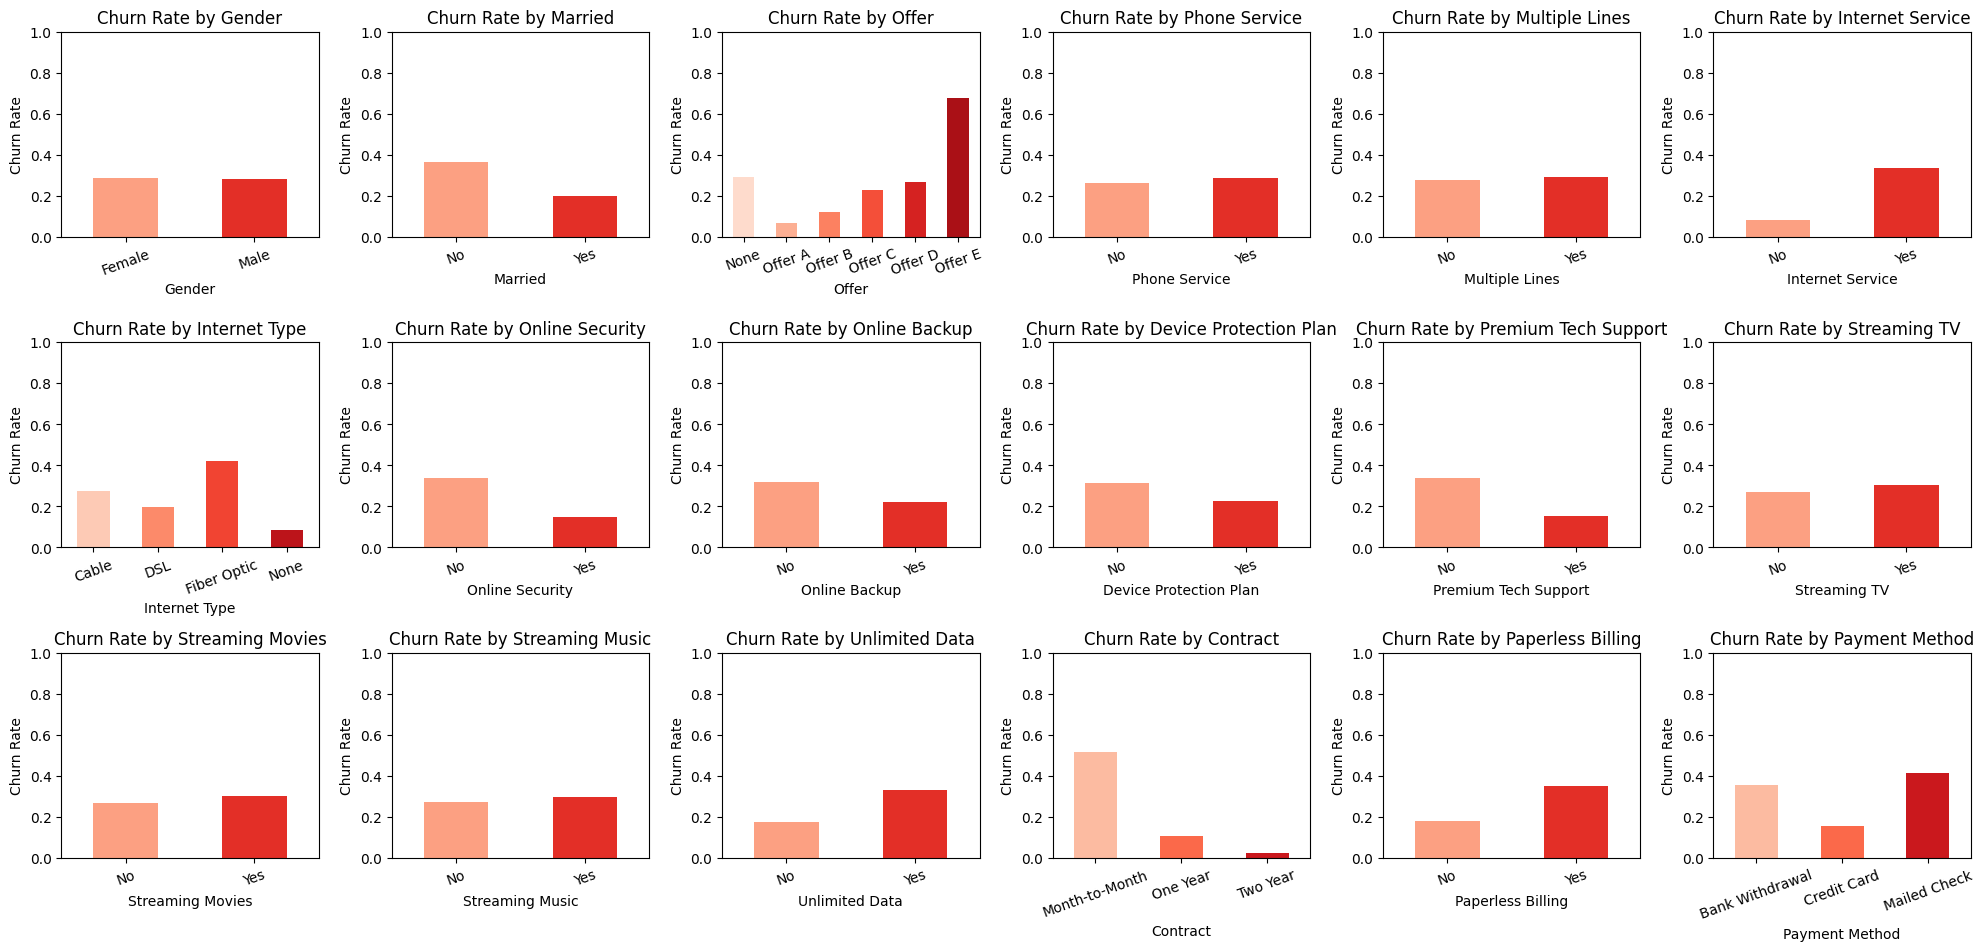

In [205]:
cat_cols = list(df.drop(columns=["Customer ID", "City", "Churn Reason", "Customer Status", "Churn Category"]).select_dtypes(include='object').columns)



fig, axes = plt.subplots(5, 6, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    churn_rate = df.groupby(col)['Churn'].mean().sort_index()
    palette = sns.color_palette("Reds", len(churn_rate))

    churn_rate.plot(kind='bar', ax=axes[i], color=palette)

    axes[i].set_title(f"Churn Rate by {col}")
    axes[i].set_ylabel("Churn Rate")
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=20)

# remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

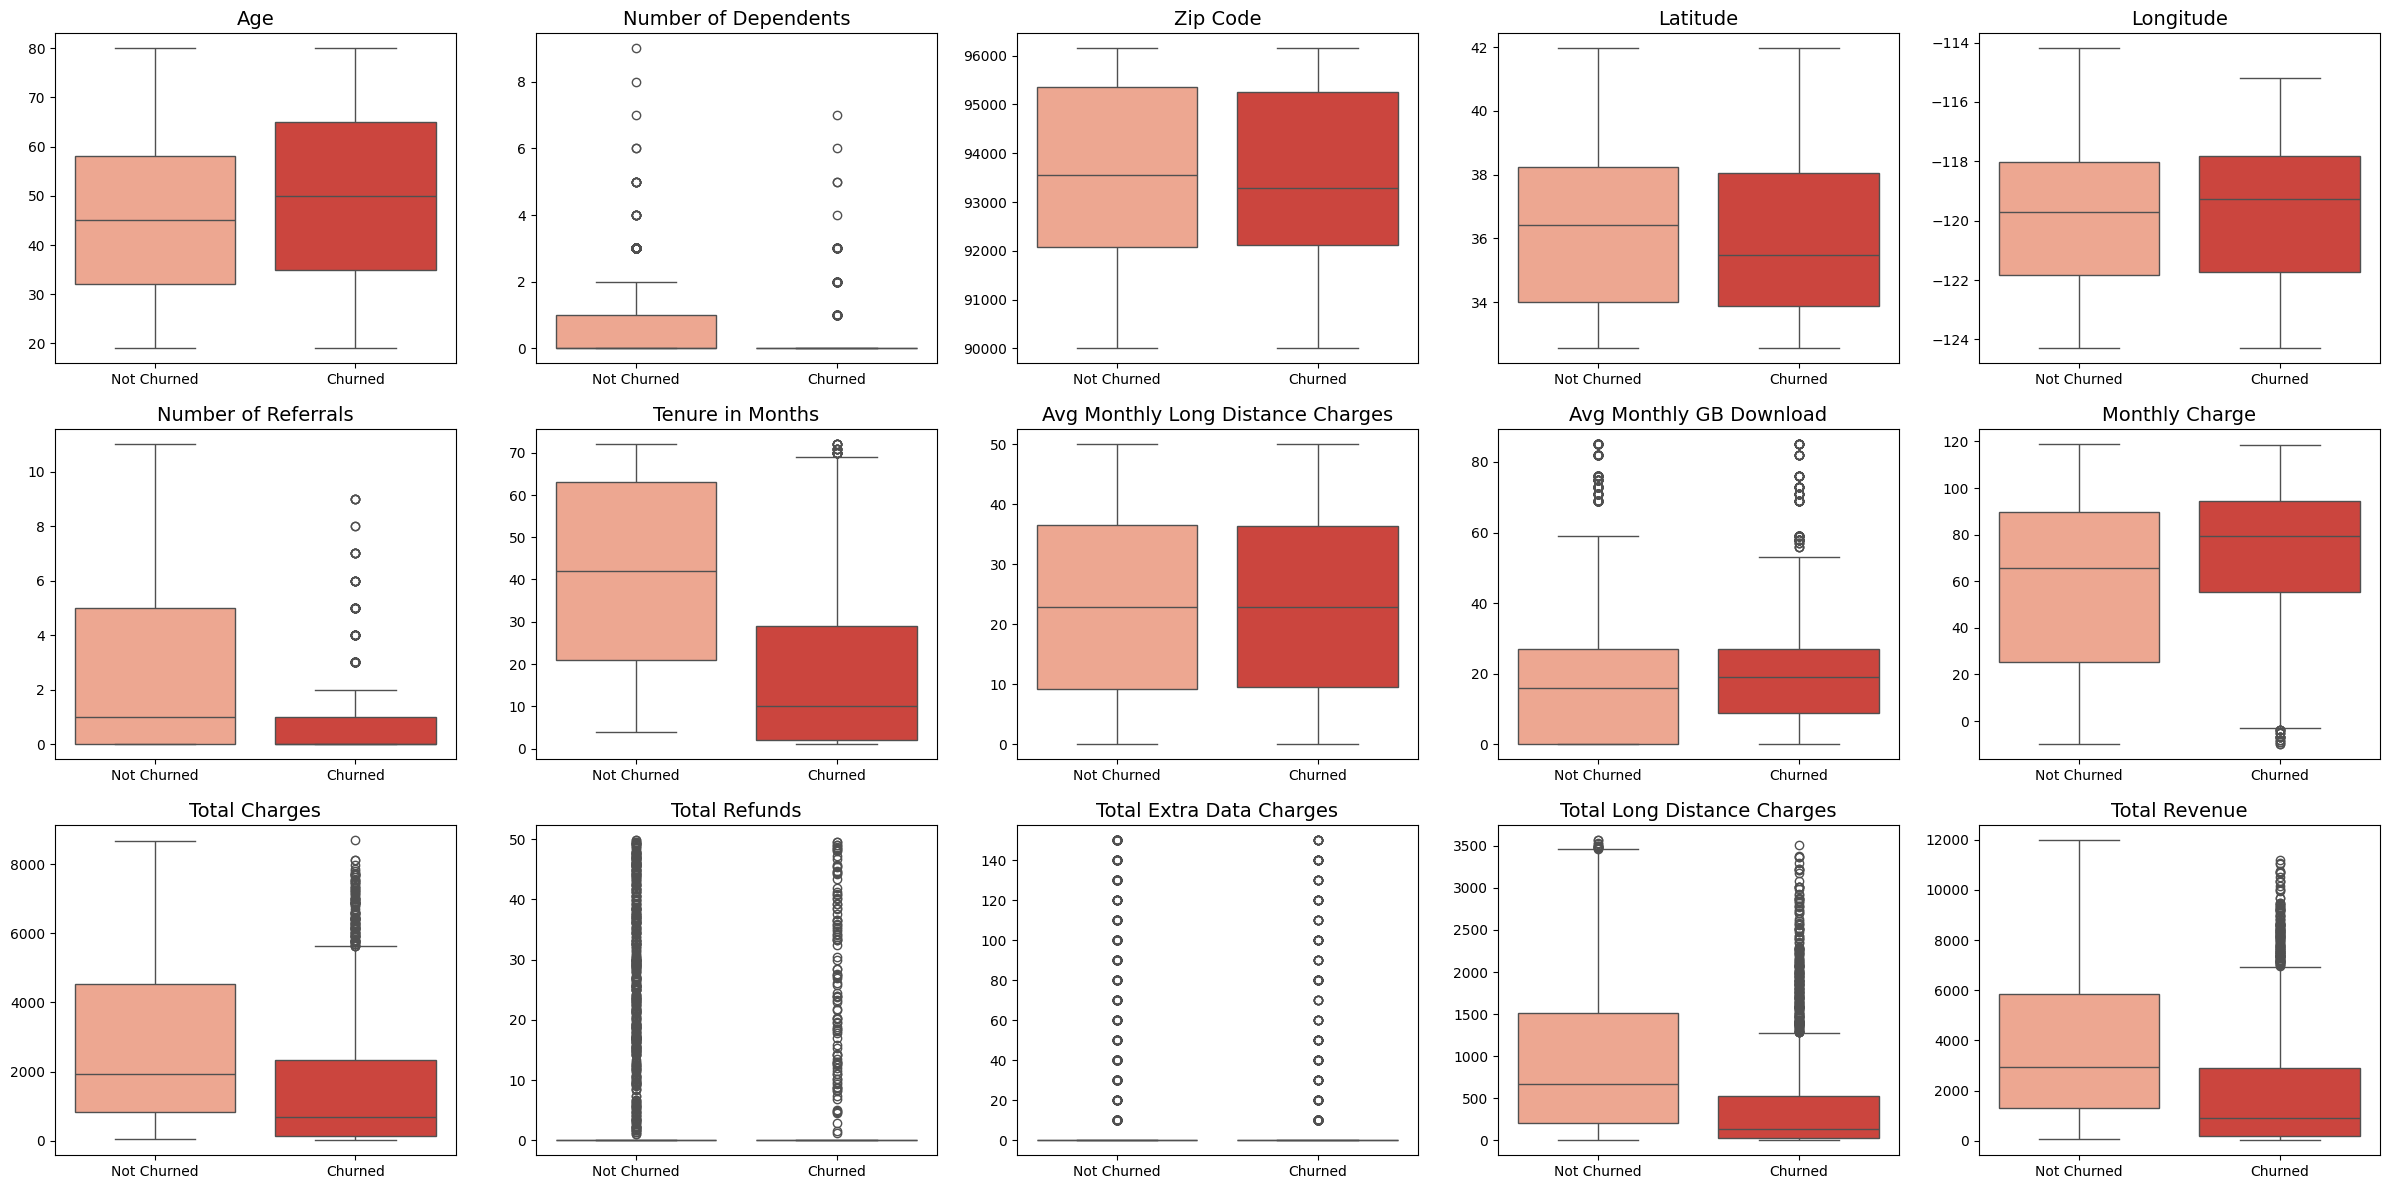

In [206]:
num_cols = [
    cname for cname in df.columns
    if df[cname].dtype in ['int64', 'float64']
    and cname != 'Churn'
    and df[cname].nunique() > 2
]

fig, axes = plt.subplots(6, 5, figsize=(30, 30))
axes = axes.flatten()
color_palette = sns.color_palette("Reds", 2)
palette = {"0": color_palette[0], "1": color_palette[1]}

for i, col in enumerate(num_cols):
    ax = axes[i]

    sns.boxplot(
        data=df,
        x='Churn',
        y=col,
        ax=ax,
        palette=palette
    )

    ax.set_title(col, fontsize=14)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels(['Not Churned', 'Churned'])

# remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


In [207]:
yes_no_cols = [
    'Married', 'Phone Service', 'Multiple Lines', 'Internet Service',
    'Online Security', 'Online Backup', 'Device Protection Plan',
    'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
    'Streaming Music', 'Unlimited Data', 'Paperless Billing'
]

for col in yes_no_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})


In [208]:
# selected_features = [
#     # Loyalty
#     'Tenure in Months', 'Number of Referrals',

#     # Contract & billing
#     'Contract', 'Paperless Billing', 'Payment Method',

#     # Pricing
#     'Monthly Charge',

#     # Services
#     'Phone Service', 'Multiple Lines',
#     'Internet Service', 'Internet Type',
#     'Online Security', 'Online Backup',
#     'Device Protection Plan', 'Premium Tech Support',
#     'Streaming TV', 'Streaming Movies', 'Streaming Music',
#     'Unlimited Data'
# ]

# X = df[selected_features]
# y = df['Churn']

In [209]:
df['Tenure_MTM'] = (
    df['Tenure in Months'] *
    (df['Contract'] == 'Month-to-Month').astype(int)
)
df['HighCharge_Fiber'] = (
    df['Monthly Charge'] *
    (df['Internet Type'] == 'Fiber Optic').astype(int)
)


selected_features = [
    # Loyalty
    'Tenure in Months', 'Number of Referrals',

    # Contract & billing
    'Contract', 'Paperless Billing', 'Payment Method', "Offer",

    # Pricing
    'Monthly Charge', 'Internet Service', 'Internet Type',
    'Online Security', 'Premium Tech Support',
    'Unlimited Data', 'Online Backup', 'Device Protection Plan',

    # Interactions
    # 'Tenure_MTM', 'HighCharge_Fiber'
]

X = df[selected_features]
y = df['Churn']


In [210]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [211]:
num_cols = [
    'Tenure in Months', 'Number of Referrals',
    'Monthly Charge'
]

cat_cols = [
    'Contract', 'Payment Method', 'Internet Type', "Offer"
]

bin_cols = [c for c in selected_features if c not in num_cols + cat_cols]

In [248]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop=None, handle_unknown='ignore'), cat_cols),
        ('bin', 'passthrough', bin_cols)
    ]
)

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=2000))  # better for interpretability
])

clf.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [249]:
y_proba = clf.predict_proba(X_test)[:, 1]
threshold = 0.4

y_pred = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       944
           1       0.68      0.77      0.72       374

    accuracy                           0.83      1318
   macro avg       0.79      0.81      0.80      1318
weighted avg       0.84      0.83      0.83      1318

ROC-AUC: 0.8986931251699447


In [214]:
feature_names = clf.named_steps['preprocess'].get_feature_names_out()
coefficients = clf.named_steps['model'].coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

coef_df


,Feature,Coefficient
14,cat__Offer_Offer A,0.901124
3,cat__Contract_Month-to-Month,0.899937
2,num__Monthly Charge,0.597577
18,cat__Offer_Offer E,0.350772
19,bin__Paperless Billing,0.286864
8,cat__Payment Method_Mailed Check,0.280161
9,cat__Internet Type_Cable,0.116614
11,cat__Internet Type_Fiber Optic,0.086240
25,bin__Device Protection Plan,0.001908
20,bin__Internet Service,-0.003828
